## Inverse problems in image processing - TD 9
                                  
                                  e-mail: jayousi@unice.fr
                                  date: 17 / 03 / 2023

In [1]:
import numpy as np
from scipy.linalg import orth
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F 

device = torch.device("cpu")

In Sparse Coding (SC), input vectors are reconstructed using a sparse linear combination of basis vectors. SC has become a popular method for extracting features from data. For a given input, SC minimizes a quadratic reconstruction error with an L1 penalty term on the code. 

In this TD we will describe and implement two algrorithms for finding sparse codes: the Iterative Shrinkage and Thresholding Algorithm (ISTA) [1],[2] and the Learned ISTA (LISTA) [3] 


## ISTA Implementation

First of all, we will define the shrinkage function that we will need in the ISTA algorithm:

In [3]:
def Shrinkage(x, theta):
    return np.multiply(np.sign(x), np.maximum(np.abs(x) - theta, 0))

The pseudocode of ISTA:

<div>
<img src="image1.JPG" width="400"/>
</div>


Find bellow the implementation of the ISTA algorithm. The sparse solution and the reconstruction error are returned. Please, fill in the gaps.

In [3]:
def ista(X, W_d, a, L, max_iter, eps):
    eig, eig_vector = np.linalg.eig(W_d.T * W_d)
    assert L > np.max(eig)
    del eig, eig_vector
    recon_errors=[]
    Z_old = np.zeros((W_d.shape[1], 1))
    for _ in range(max_iter):
        grad = W_d.T * (W_d * Z_old - X)
        Z_new = Shrinkage(Z_old-1/L*grad, a/L)
        if np.sum(np.abs(Z_new - Z_old)) <= eps: break
        Z_old = Z_new
        recon_error = np.linalg.norm(X - W_d * Z_new, 2)**2
        recon_errors.append(recon_error)
    return Z_new,recon_errors

## From ISTA to LISTA

<div>
<img src="image2.JPG" width="500"/>
</div>

**Top:** 
The block diagram of the ISTA algorithm for sparse coding. The optimal sparse code is the fixed point of $Z(k + 1) = h_\theta(W_e X + S Z(k))$ where $X$ is the input, $h_\theta$ is a coordinate-wise shrinking function with threshold $\theta$, $W_e$ is the transpose of the dictionary matrix $W_d$ (whose columns are the basis vectors), and $S$ is $W_d^T W_d$. 

**Bottom:**
The approximator “Learned ISTA”, uses a time unfolded version of the ISTA block diagram, truncated to a fixed number of iterations (3 here). The matrices $W_e$ and $S$, are learned, so as to minimize the approximation error to the optimal sparse code on a given dataset. The method allows us to impose restrictions on $S$ so as to further reduce the computational burden (e.g. keeping many terms at 0, or using a low-rank factorized form).

#### Questions

1. Using the notation from Algorithm 1, express $W_e$ and $S$.

$Z(k + 1) = h_\theta(W_e X + S Z(k))$ with $W_e = \frac{1}{L} W_d^T$, $S = \mathbb{I} -\frac{1}{L} W_d^T W$ and $\theta = \alpha/L$


## LISTA Implementation

Find bellow the implementation of the LISTA algorithm. 

In [4]:
class LISTA(nn.Module):
    def __init__(self, n, m, W_d, max_iter, L, theta):
        
        """
        # Arguments
            n: int, dimensions of the measurement
            m: int, dimensions of the sparse signal
            W_d: array, dictionary
            max_iter:int, max number of internal iteration
            L: Lipschitz const 
            theta: Thresholding
        """
        
        super(LISTA, self).__init__()
        self._W = nn.Linear(in_features=n, out_features=m, bias=False)
        self._S = nn.Linear(in_features=m, out_features=m, bias=False)
        self.shrinkage = nn.Softshrink(theta)
        self.theta = theta
        self.max_iter = max_iter
        self.A = W_d
        self.L = L
      
    # Initialization of the weights (based on the Dictionary) 
    def weights_init(self):
        A = self.A.cpu().numpy()
        L = self.L
        S = torch.from_numpy(np.eye(A.shape[1])-(1/L)*np.matmul(A.T,A))
        S = S.float().to(device)
        W = torch.from_numpy((1/L)*A.T)
        W = W.float().to(device)
        self._S.weight = nn.Parameter(S)
        self._W.weight = nn.Parameter(W)
        
    def forward(self,Y):
        X = self.shrinkage(self._W(Y))
        if self.max_iter == 1:
            return X
        for _ in range(self.max_iter):
            X = self.shrinkage(self._W(Y) + self._S(X))
        return X
    
def train_lista(Y, dictionary, a, L, max_iter=30):
    n, m = dictionary.shape
    n_samples = Y.shape[0]
    batch_size = 128
    steps_per_epoch = n_samples//batch_size
    
    # Convert to tensors  
    Y = torch.from_numpy(Y)
    Y = Y.float().to(device)
    w_d = torch.from_numpy(dictionary)
    w_d = w_d.float().to(device)

    net = LISTA(n,m,w_d,max_iter=30,L=L,theta=a/L)
    net = net.float().to(device)
    net.weights_init()

    # build optimizer and criterion
    learning_rate = 1e-1
    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()
    all_zeros = torch.zeros(batch_size,m).to(device)
    optimizer = torch.optim.SGD(net.parameters(),lr=learning_rate,momentum=0.9)

    loss_list = []
    for epoch in range(100):
        if epoch%10==0: print('epoch: %s' %epoch)
        index_samples = np.random.choice(a=n_samples,size=n_samples,replace=False,p=None)
        Y_shuffle = Y[index_samples]
        for step in range(steps_per_epoch):

            Y_batch = Y_shuffle[step*batch_size:(step+1)*batch_size]
            optimizer.zero_grad()

            # get the outputs
            x_h = net(Y_batch)
            y_h = torch.mm(x_h,w_d.T)

            # compute the loss 
            loss1 = criterion1(Y_batch.float(), y_h.float())
            loss2 = a * criterion2(x_h.float(), all_zeros.float())
            loss = loss1 + loss2

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                loss_list.append(loss.detach().data)
    return net, loss_list

        

For LISTA, an additional training step is required.

Let's first train LISTA.

The sparse signal dimension is 1000, the measurement signal dimension is 256, the signal sparsity is 5, and 5000 training samples are used.

In [5]:
# dimensions of the sparse signal, measurement and sparsity 
m,n,k = 1000, 256, 5

# generate dictionary 
Psi=np.eye(m)
Phi = np.random.randn(n,m)
Phi = np.transpose(orth(np.transpose(Phi)))
w_d = np.dot(Phi,Psi)

# number of training samples 
N=5000

# generate Sparse Signal the z and Measurement x 
z = np.zeros((N,m))
x = np.zeros((N,n))

for I in range (N):
    index_k = np.random.choice(a=m,size=k,replace=False)
    z[I,index_k] = .5*np.random.randn(k,1).reshape(-1)
    x[I] = np.dot(w_d,z[I,:])
    
# train LISTA
net,err_list=train_lista(x,w_d,0.05,2)

epoch: 0
epoch: 10
epoch: 20
epoch: 30
epoch: 40
epoch: 50
epoch: 60
epoch: 70
epoch: 80
epoch: 90


#### Questions

2. Try to understand the algorithm. Do you have any questions?


3. Which parameters are trained?

$W$ (or $W_e$ according to the notation of LISTA block diagram) and $S$


4. Using the notation of Algorithm 1, express the threshold "theta" given as an input in the class above? Is this parameter trained?  

$\theta = \alpha/L$: in the above implementation this parameter is not trained. 

## An example of sparse reconstruction

Create a test dataset

In [6]:
# dimensions of the sparse signal, measurement and sparsity 
m,n,k = 1000, 256, 5

# number of test examples 
N=1

# generate Sparse Signal the z and Measurement x 
z = np.zeros((N,m))
x = np.zeros((N,n))

for I in range (N):
    index_k = np.random.choice(a=m,size=k,replace=False)
    z[I,index_k] = .5*np.random.randn(k,1).reshape(-1)
    x[I] = np.dot(w_d,z[I,:])

Test the performance of ISTA and LISTA algorithm. Compare the sparse solutions obtained.

C:\Users\vstergio\AppData\Local\Temp/ipykernel_13484/320047054.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,2)
C:\Users\vstergio\AppData\Local\Temp/ipykernel_13484/320047054.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,2)


Error of ISTA reconstruction: 0.4634670723772755
Error of LISTA reconstruction: 0.42966898256531966


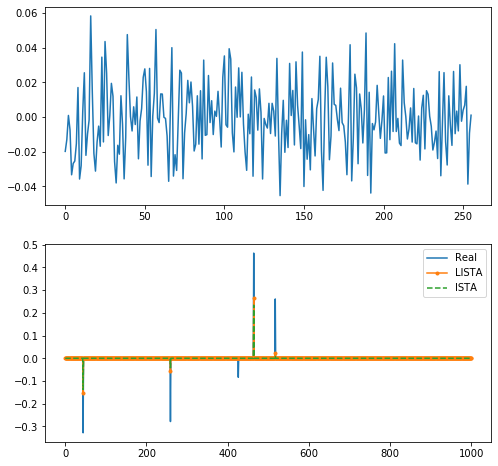

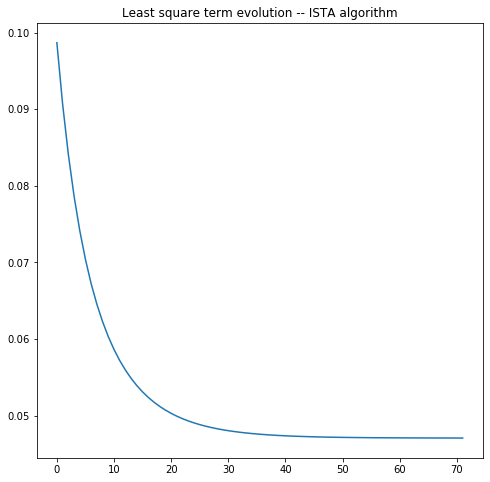

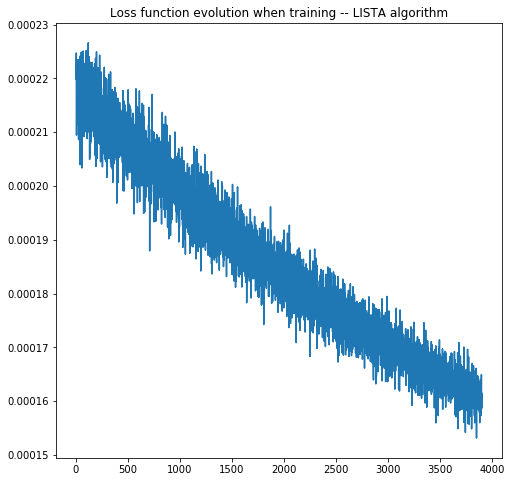

In [10]:
# Plot Measurement x
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(x.flatten())

# Plot Ground Truth of Sparse Signal
plt.subplot(2, 1, 2)
plt.plot(z.flatten(), label='Real')

# Reconstruction using LISTA
z_recon_lista = net(torch.from_numpy(x).float().to(device))
z_recon_lista = z_recon_lista.detach().cpu().numpy()

# Plot LISTA solution
plt.subplot(2, 1, 2)
plt.plot(z_recon_lista.flatten(), '.-', label='LISTA')
plt.legend()

# Reconstruction using ISTA
z_recon_ista, recon_errors_ista = ista(np.mat(x).T, np.mat(w_d), 0.05, 2, 1000, 0.00001)
# Plot ISTA solution
plt.subplot(2, 1, 2)
plt.plot(z_recon_ista,'--', label='ISTA')
plt.legend()


plt.figure
plt.figure(figsize=(8,8))
plt.plot(recon_errors_ista)
plt.title("Least square term evolution -- ISTA algorithm")

plt.figure
plt.figure(figsize=(8,8))
plt.plot(err_list)
plt.title("Loss function evolution when training -- LISTA algorithm")

print('Error of ISTA reconstruction:',np.linalg.norm(z_recon_ista.flatten() - z.flatten()))
print('Error of LISTA reconstruction:',np.linalg.norm(z_recon_lista.flatten() - z.flatten()))

#### Questions

5. You can plot the least square term evolution (recon_error) when ISTA algorithm was used. Also, you can plot the loss function evolution while LISTA has been used.

6. Evaluate the reconstructions obtained using ISTA and LISTA. As we already know the ground truth vector ($z_{GT}$) we can compute for example the error: error = $\| z_{GT} - z_{rec}\|_2$

7. Play with the training parameters: number of training samples (N), number of epochs, learning_rate. What do you observe?

8. Play with the parameter that controls the sparsity level ($a$) in both ISTA/LISTA. 


This TD is based on the article found on: https://blog.karthisoftek.com/ where ISTA and LISTA implementations were provided.

#### Main References:
[1] Daubechies, I., Defrise, M. and De Mol, C. (2004), An iterative thresholding algorithm for linear inverse problems with a sparsity constraint. Comm. Pure Appl. Math., 57: 1413-1457. https://doi.org/10.1002/cpa.20042

[2] Beck, A. & Teboulle, M. (2009). A fast iterative shrinkage-thresholding algorithm for linear inverse problems. SIAM Journal on Imaging Sciences, 2, 183--202.
https://www.ceremade.dauphine.fr/~carlier/FISTA

[3] Gregor, K. & LeCun, Y. (2010). Learning Fast Approximations of Sparse Coding.. In J. Fürnkranz & T. Joachims (eds.), ICML (p./pp. 399-406), : Omnipress. 
https://icml.cc/Conferences/2010/papers/449.pdf